<a target="_blank" href="https://colab.research.google.com/github/NX-AI/tirex/blob/main/examples/quick_start_tirex.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Quick Start In Colab"/>
</a>

### Install TiRex package

In [10]:
# !pip install 'tirex-ts[notebooks,gluonts,hfdataset]' -q
# !pip install tirex-ts pandas matplotlib 

### Imports and Load Data

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import os

from tirex import ForecastModel, load_model
from tirex.util import plot_forecast

# set default figure size for all plots
plt.rcParams["figure.figsize"] = (12, 6)

# ============================================================================
# OFFLINE MODE SETUP - Choose one option below:
# ============================================================================

# Option 1: Use local cache (if weights downloaded)
# setup_offline_env()

# Option 2: Use custom weights path
# setup_offline_env("/path/to/your/weights/directory")

# Option 3: Use environment variable (set TIREX_WEIGHTS_PATH before running)
# If TIREX_WEIGHTS_PATH is set, uncomment:
# setup_offline_env()

# Option 4: Manual environment setup (no setup_offline_env needed)
# Just ensure weights are at: ~/.cache/tirex/weights/model.ckpt

# See OFFLINE_NO_INTERNET.md for alternative approaches if download times out

In [2]:
# !cd /Users/sudhanshu_shukla/Study/AI/tirex/
# tirex/tests/data && curl -O https://raw.githubusercontent.com/NX-AI/tirex/refs/heads/main/t
# ests/data/loop_seattle_5T.csv && curl -O https://raw.githubusercontent.com/NX-AI/tirex/refs
# /heads/main/tests/data/air_passengers.csv

In [12]:
data_short = pd.read_csv("../tests/data/air_passengers.csv").values.reshape(-1)
data_long = pd.read_csv("../tests/data/loop_seattle_5T.csv").values.reshape(-1)

### Load Model

In [13]:
import os
os.environ['TIREX_WEIGHTS_PATH'] = '/Users/sudhanshu_shukla/.cache/tirex/weights'
from tirex import load_model

In [14]:
model: ForecastModel = load_model("NX-AI/TiRex")
# If HuggingFace is blocked, setup_offline_env() above will use local weights instead

### Generate Forecast

<Axes: >

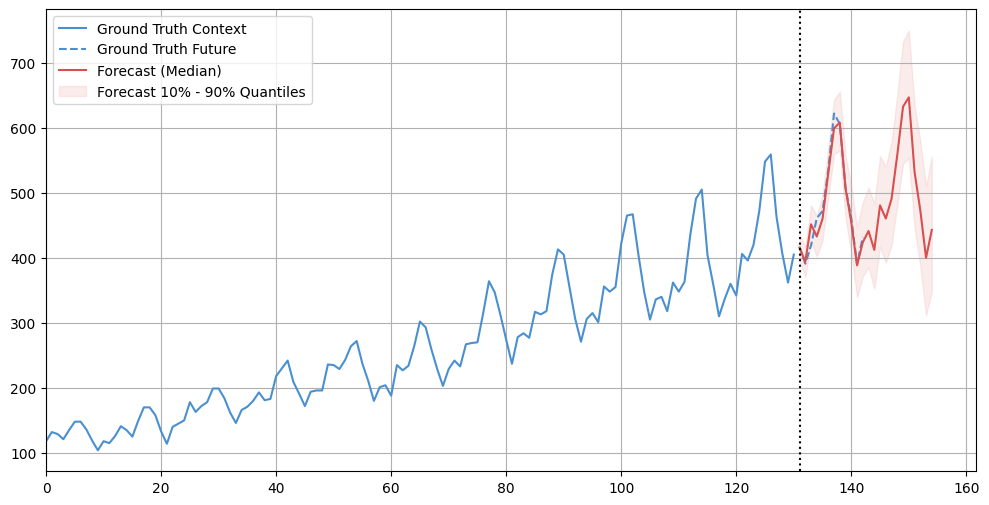

In [15]:
# Short Horizon - Example
ctx_s, future_s = np.split(data_short, [-12])
quantiles, mean = model.forecast(ctx_s, prediction_length=24)
plot_forecast(ctx_s, quantiles[0], future_s)

<Axes: >

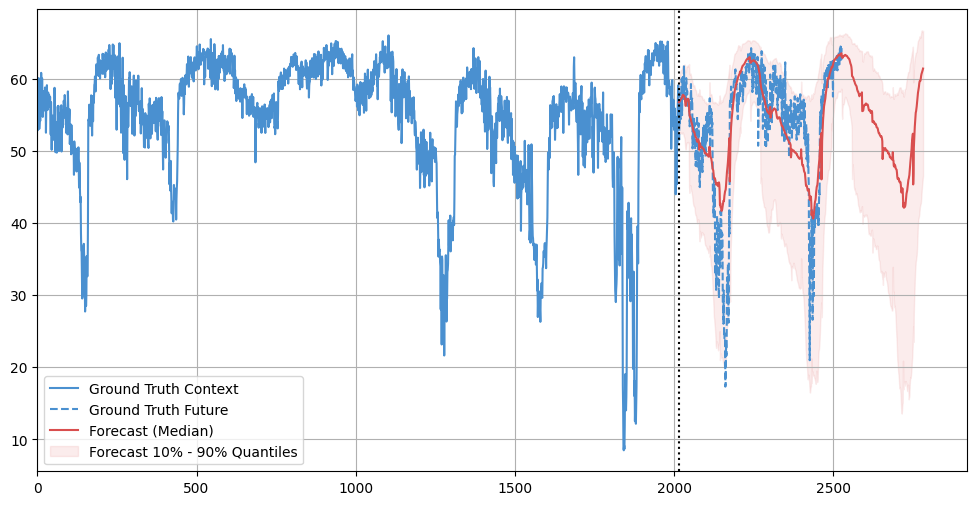

In [16]:
# Long Horizon - Example
ctx_l, future_l = np.split(data_long, [-512])
quantiles, mean = model.forecast(ctx_l, prediction_length=768)
plot_forecast(ctx_l, quantiles[0], future_l)

### Input Options

TiRex supports forecasting with different input types

In [17]:
data = torch.tensor(data_short)

# Torch tensor (2D or 1D)
quantiles, means = model.forecast(context=data, prediction_length=24)
print("Predictions (Torch tensor):\n", type(quantiles), quantiles.shape)

# List of Torch tensors (List of 1D) - will be padded
list_torch_data = [data, data, data]
quantiles, means = model.forecast(context=list_torch_data, prediction_length=24, batch_size=2)
print("Predictions (List of Torch tensors):\n", type(quantiles), quantiles.shape)

# NumPy array (2D or 1D)
quantiles, means = model.forecast(context=data.numpy(), prediction_length=24, output_type="torch")
print("Predictions (NumPy):\n", type(quantiles), quantiles.shape)


# List of NumPy arrays (List of 1D) - will be padded
list_numpy_data = [data.numpy()]  # Split into 3 sequences
quantiles, means = model.forecast(context=list_numpy_data, prediction_length=24)
print("Predictions (List of NumPy arrays):\n", type(quantiles), quantiles.shape)


# GluonTS Dataset
try:
    from typing import cast

    from gluonts.dataset import Dataset

    gluon_dataset = cast(Dataset, [{"target": data, "item_id": 1}, {"target": data, "item_id": 22}])
    quantiles, means = model.forecast_gluon(gluon_dataset, prediction_length=24)
    print("Predictions GluonDataset:\n", type(quantiles), quantiles.shape)
    # If you use also `glutonts` as your output type the start_time and item_id get preserved accordingly
    predictions_gluon = model.forecast_gluon(gluon_dataset, prediction_length=24, output_type="gluonts")
    print("Predictions GluonDataset:\n", type(predictions_gluon), type(predictions_gluon[0]))
except Exception as e:
    print(e)
    # To use the gluonts function you need to install the optional dependency
    # pip install tirex[gluonts]
    pass

Predictions (Torch tensor):
 <class 'torch.Tensor'> torch.Size([1, 24, 9])
Predictions (List of Torch tensors):
 <class 'torch.Tensor'> torch.Size([3, 24, 9])
Predictions (NumPy):
 <class 'torch.Tensor'> torch.Size([1, 24, 9])
Predictions (List of NumPy arrays):
 <class 'torch.Tensor'> torch.Size([1, 24, 9])
No module named 'gluonts'


### Output Options


TiRex supports different output types for the forecasts

In [9]:
data = torch.tensor(data_short)

# Default: 2D Torch tensor
quantiles, means = model.forecast(context=data, prediction_length=24, output_type="torch")
print("Predictions:\n", type(quantiles), quantiles.shape)


# 2D Numpy Array
quantiles, means = model.forecast(context=data, prediction_length=24, output_type="numpy")
print("Predictions:\n", type(quantiles), quantiles.shape)


# Iterate by patch
# You can also use the forecast function as iterable. This might help with big datasets. All output_types are supported
for i, fc_batch in enumerate(
    model.forecast(context=[data, data, data, data, data], batch_size=2, output_type="torch", yield_per_batch=True)
):
    quantiles, means = fc_batch
    print(f"Predictions batch {i}:\n", type(quantiles), quantiles.shape)


try:
    # QuantileForecast (GluonTS)
    predictions_gluonts = model.forecast(context=data, prediction_length=24, output_type="gluonts")
    print("Predictions (GluonTS Quantile Forecast):\n", type(predictions_gluon), type(predictions_gluon[0]))
    predictions_gluonts[0].plot()
except Exception as e:
    print(e)
    # To use the gluonts function you need to install the optional dependency
    # pip install tirex[gluonts]

Predictions:
 <class 'torch.Tensor'> torch.Size([1, 24, 9])
Predictions:
 <class 'numpy.ndarray'> (1, 24, 9)
Predictions batch 0:
 <class 'torch.Tensor'> torch.Size([2, 32, 9])
Predictions batch 1:
 <class 'torch.Tensor'> torch.Size([2, 32, 9])
Predictions batch 2:
 <class 'torch.Tensor'> torch.Size([1, 32, 9])
output_type glutonts needs GluonTs but GluonTS is not available (not installed)!


## Torch compile
Use `compile=True` to speed up the sLSTM layers when using the torch backend.

In [ ]:
# model: ForecastModel = load_model("NX-AI/TiRex", backend="torch", device="cuda", compile=True)